In [1]:
import pandas as pd
import numpy as np

from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import warnings
warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesse
 
import shap
from dataset import engine, RFM, Churn, Engagement, RFM_engage
from models import CLFSwitcher, Transform, Pipe, parameters
from sklearn.model_selection import GridSearchCV

In [2]:
rfm = RFM(engine)

engage = Engagement(engine)

churn = Churn(engine)
churn = churn.get_dataset()[['customer_id', 'churn']]

In [3]:
engage = RFM_engage(rfm, engage)

In [4]:
data = engage
X = data.get_X()
y = data.get_y()
ct = Transform(data)
X, y = ct.get_Xy()
# ct.inverse_transform(pd.concat([X, y], axis=1))
# y

In [5]:
pipeline = Pipe(ct).get_pipeline()
def train(X, y, pipeline, parameters):
        grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=12, return_train_score=True, verbose=2)
        grid_search.fit(X, y)
        return grid_search, grid_search.best_estimator_[-1]
_, best_estimator = train(X, y, pipeline, parameters)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] END clf__estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), clf__estimator__learning_rate=1e-05, clf__estimator__max_depth=5, clf__estimator__n_estimators=1000, clf__estimator__random_state=123; total time=   3.9s
[CV] 

In [ ]:
best_estimator.explain(data, ct)


 98%|===================| 391/400 [00:35<00:00]        

In [13]:
shap_df = best_estimator.get_shap(X_col='engage_month', y_col='action_type', y_val='converted')
shap_df

,shap,engage_month__converted
0,0.000101,9
1,-0.000120,5
2,0.000094,8
3,0.000009,1
4,-0.000161,3
...,...,...
95,0.000523,11
96,0.000066,5
97,-0.000326,3
98,-0.000099,3


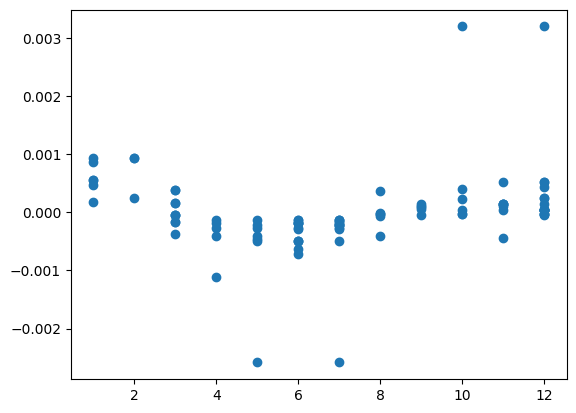

In [ ]:

plt.scatter(shap_df['engage_month__converted'], shap_df['shap'])